--- Analyzing Distribution of Pair-Eligible 'Used' Papers ---

--- Summary Statistics ---
ペア作成が可能なデータ論文の総数 ('Used'論文が2件以上): 721

[Distribution of 'Used' Paper Counts (for this eligible group)]


count    721.000000
mean       4.468793
std        9.089184
min        2.000000
25%        2.000000
50%        2.000000
75%        4.000000
max      179.000000
Name: used_paper_count, dtype: float64


[Histogram of the Distribution]


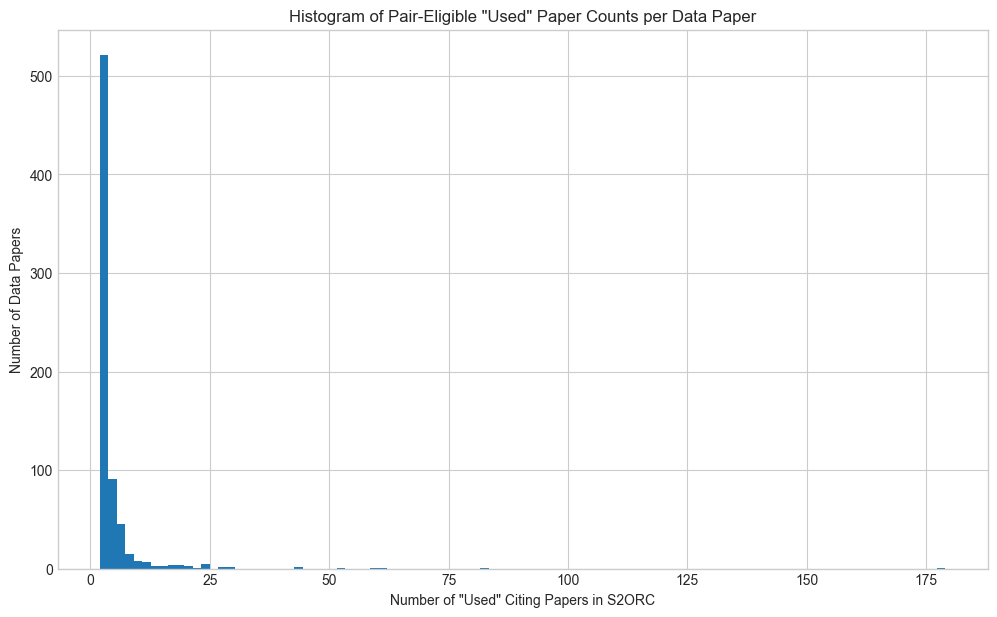

In [3]:
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# --- Step 1: 設定 ---
# データベースのパス。ローカル環境で実行するため、
# data/processed/s2orc_filtered.db にあることを前提とします。
DB_PATH = "../data/processed/s2orc_filtered.db"

# --- Step 2: データベースの分析 ---

def analyze_pair_eligible_used_distribution():
    """
    'Used'と判定された論文が2件以上あるデータ論文のみを対象に、
    その分布を調査・可視化する。
    """
    print("--- Analyzing Distribution of Pair-Eligible 'Used' Papers ---")

    if not os.path.exists(DB_PATH):
        print(f"❌ Error: Database file not found at {DB_PATH}")
        print("   Please ensure the database file 's2orc_filtered.db' is located in the '../data/processed/' directory.")
        return

    try:
        with sqlite3.connect(DB_PATH) as conn:
            # テーブルの存在を確認
            cursor = conn.cursor()
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='positive_candidates'")
            if cursor.fetchone() is None:
                print("⚠️ `positive_candidates` table not found.")
                return

            # --- 2.1: 'Used'と判定された論文をデータ論文ごとに集計 ---
            # llm_annotation_status = 1 (Used) の論文をカウント
            query = """
                SELECT
                    cited_datapaper_doi,
                    COUNT(citing_doi) AS used_paper_count
                FROM
                    positive_candidates
                WHERE
                    llm_annotation_status = 1
                GROUP BY
                    cited_datapaper_doi
                HAVING
                    COUNT(citing_doi) >= 2;
            """
            df_counts = pd.read_sql_query(query, conn)
            
            if df_counts.empty:
                print("\nNo data papers found with 2 or more 'Used' citing papers.")
                return

            # --- 2.2: 主要な統計情報を表示 ---
            total_data_papers_eligible = len(df_counts)
            
            print("\n--- Summary Statistics ---")
            print(f"ペア作成が可能なデータ論文の総数 ('Used'論文が2件以上): {total_data_papers_eligible:,}")
            
            print("\n[Distribution of 'Used' Paper Counts (for this eligible group)]")
            display(df_counts['used_paper_count'].describe())

            # --- 2.3: 分布をヒストグラムで可視化 ---
            plt.style.use('seaborn-v0_8-whitegrid')
            plt.figure(figsize=(12, 7))
            
            max_count = df_counts['used_paper_count'].max()
            # ビン（棒）の数を調整。最大値が小さい場合はその数、多い場合は100に制限
            bins = int(max_count) if max_count < 100 else 100
            
            # y軸（論文数）を対数スケールでプロット
            plt.hist(df_counts['used_paper_count'], bins=bins)
            
            plt.title('Histogram of Pair-Eligible "Used" Paper Counts per Data Paper')
            plt.xlabel('Number of "Used" Citing Papers in S2ORC')
            plt.ylabel('Number of Data Papers')

            print("\n[Histogram of the Distribution]")
            plt.show()

    except Exception as e:
        print(f"💥 An error occurred: {e}")

# --- 実行 ---
analyze_pair_eligible_used_distribution()

In [4]:
import pandas as pd
import sqlite3
import os
from IPython.display import display

# --- Step 1: 設定 ---
DB_PATH = "../data/processed/s2orc_filtered.db"

# --- Step 2: データベースの分析 ---

def analyze_used_paper_count_ge3():
    """
    'Used'と判定された論文が3件以上あるデータ論文の数を集計する。
    """
    print("--- Counting Data Papers with 3 or More 'Used' Papers ---")

    if not os.path.exists(DB_PATH):
        print(f"❌ Error: Database file not found at {DB_PATH}")
        return

    try:
        with sqlite3.connect(DB_PATH) as conn:
            # --- 'Used'と判定された論文をデータ論文ごとに集計 ---
            # ▼▼▼ 修正点: HAVING句を '>= 3' に変更 ▼▼▼
            query = """
                SELECT
                    cited_datapaper_doi,
                    COUNT(citing_doi) AS used_paper_count
                FROM
                    positive_candidates
                WHERE
                    llm_annotation_status = 1
                GROUP BY
                    cited_datapaper_doi
                HAVING
                    COUNT(citing_doi) >= 3;
            """
            df_counts = pd.read_sql_query(query, conn)
            
            if df_counts.empty:
                print("\nNo data papers found with 3 or more 'Used' citing papers.")
                return

            # --- 結果を表示 ---
            count_ge3 = len(df_counts)
            print(f"\n✅ 'Used'論文が3件以上あるデータ論文の総数: {count_ge3:,}件")

            # 上位10件を参考として表示
            print("\n--- Top 10 Data Papers (by 'Used' paper count) ---")
            display(df_counts.sort_values(by='used_paper_count', ascending=False).head(10))

    except Exception as e:
        print(f"💥 An error occurred: {e}")

# --- 実行 ---
analyze_used_paper_count_ge3()

--- Counting Data Papers with 3 or More 'Used' Papers ---

✅ 'Used'論文が3件以上あるデータ論文の総数: 340件

--- Top 10 Data Papers (by 'Used' paper count) ---


,cited_datapaper_doi,used_paper_count
223,10.1038/S41597-020-0453-3,179
321,10.5194/ESSD-13-4349-2021,83
241,10.1038/S41597-020-0534-3,62
20,10.1007/S11558-019-09344-2,60
205,10.1038/S41597-020-0369-Y,52
227,10.1038/S41597-020-0462-2,44
88,10.1016/J.DIB.2019.104863,44
319,10.5194/ESSD-13-3907-2021,30
15,10.1002/GDJ3.78,29
235,10.1038/S41597-020-0495-6,28
